# XGBoost vs LightGBM

In this notebook we collect the results from all the experiments and reports the comparative difference between XGBoost and LightGBM

In [2]:
import matplotlib.pyplot as plt
import nbformat
import json
from toolz import pipe, juxt
import pandas as pd
import seaborn
from toolz import curry

from bokeh.io import show, output_notebook
from bokeh.charts import Bar
from bokeh.models.renderers import GlyphRenderer
from bokeh.models.glyphs import Rect
from toolz import curry
from bokeh.io import export_svgs
from IPython.display import SVG, display

%matplotlib inline 

In [3]:
output_notebook()

Loading BokehJS ...

We are going to read the results from the following notebooks

In [4]:
notebooks = {
    'Airline':'01_airline.ipynb',
    'BCI': '02_BCI.ipynb',
    'Football': '03_football.ipynb',
    'Amazon': '04_PlanetKaggle.ipynb',
    'Fraud': '05_FraudDetection.ipynb'
}

In [5]:
def read_notebook(notebook_name):
    with open(notebook_name) as f:
        return nbformat.read(f, as_version=4)

In [6]:
def results_cell_from(nb):
    for cell in nb.cells:
        if cell['cell_type']=='code' and cell['source'].startswith('# Results'):
            return cell

In [7]:
def extract_text(cell):
    return cell['outputs'][0]['text']

In [8]:
@curry
def remove_line_with(match_str, json_string):
    return '\n'.join(filter(lambda x: match_str not in x, json_string.split('\n')))

In [9]:
def process_nb(notebook_name):
    return pipe(notebook_name,
                read_notebook,
                results_cell_from,
                extract_text,
                remove_line_with('total RAM usage'),
                json.loads)

Here we collect the results from all the exeperiment notebooks. The method simply searches the notebooks for a cell that starts with # Results. It then reads that cells output in as JSON.

In [10]:
results = {nb_key:process_nb(nb_name) for nb_key, nb_name in notebooks.items()}

In [11]:
results

{'Airline': {'lgbm': {'performance': {'AUC': 0.8085689434502803,
    'Accuracy': 0.7353896817753379,
    'F1': 0.6940196231335755,
    'Precision': 0.7695546060118544,
    'Recall': 0.6319874302870966},
   'test_time': 14.591926063993014,
   'train_time': 366.37647559295874},
  'xgb': {'performance': {'AUC': 0.7864092771976574,
    'Accuracy': 0.630096137083639,
    'F1': 0.6981365687005567,
    'Precision': 0.5699044513344648,
    'Recall': 0.9008287536758128},
   'test_time': 12.680251265061088,
   'train_time': 2180.798558813054},
  'xgb_hist': {'performance': {'AUC': 0.8076206419213058,
    'Accuracy': 0.6736735917278169,
    'F1': 0.7170332167054881,
    'Precision': 0.6094592088790932,
    'Recall': 0.8707220218423469},
   'test_time': 14.63406790792942,
   'train_time': 578.727180639049}},
 'Amazon': {'lgbm': {'performance': {'Accuracy': 0.5831356086877167,
    'F1': 0.8916251743227468,
    'Precision': 0.8966667101226329,
    'Recall': 0.9062528789577522},
   'test_time': 0.228

We wish to compare LightGBM and XGBoost both in terms of performance as well as how long they took to train.

In [12]:
def average_performance_diff(dataset):
    lgbm_series = pd.Series(dataset['lgbm']['performance'])
    return 100*((lgbm_series-pd.Series(dataset['xgb']['performance']))/lgbm_series).mean()

In [13]:
def train_time_ratio(dataset):
    return dataset['xgb']['train_time']/dataset['lgbm']['train_time']

def test_time_ratio(dataset):
    return dataset['xgb']['test_time']/dataset['lgbm']['test_time']

In [14]:
metrics = juxt(average_performance_diff, train_time_ratio, test_time_ratio)
res_per_dataset = {dataset_key:metrics(dataset) for dataset_key, dataset in results.items()}

In [15]:
results_df = pd.DataFrame(res_per_dataset, index=['Perf. Difference(%)', 
                                                  'Train Time Ratio', 
                                                  'Test Time Ratio']).T

In [16]:
results_df

,Perf. Difference(%),Train Time Ratio,Test Time Ratio
Airline,-0.025994,5.952343,0.868991
Amazon,15.701026,3.721858,0.778578
BCI,6.250871,2.503829,0.711396
Football,-0.589916,3.909239,0.983060
Fraud,-1.076624,6.045945,1.060074


In [17]:
data = {
    'Train Time Ratio': results_df['Train Time Ratio'].values,
    'label': results_df.index.values
}

In [18]:
bar = Bar(data, values='Train Time Ratio', agg='mean', label=['label'], 
          plot_width=600, plot_height=400, bar_width=0.7, color='#5975a4')
bar.axis[0].axis_label=''
bar.axis[1].axis_label='Train Time Ratio'
bar.toolbar_location='above'
bar.legend[0].visible=False
show(bar)

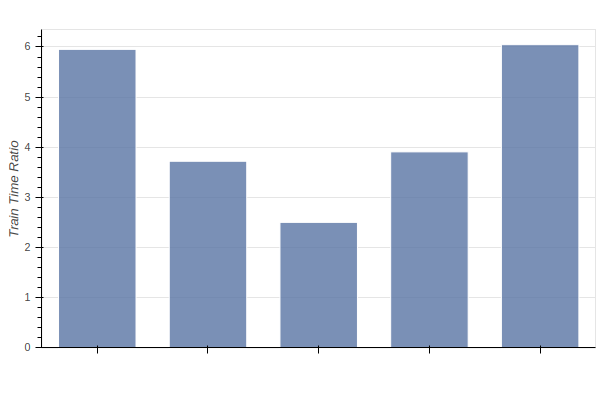

In [20]:
bar.output_backend = "svg"
export_svgs(bar, filename="xgb_vs_lgbm_train_time.svg")
display(SVG('xgb_vs_lgbm_train_time.svg'))

In [21]:
data = {
    'Perf. Difference(%)': results_df['Perf. Difference(%)'].values,
    'label': results_df.index.values
}

In [22]:
bar = Bar(data, values='Perf. Difference(%)', agg='mean', label=['label'], 
          plot_width=600, plot_height=400, bar_width=0.7, color='#5975a4')
bar.axis[0].axis_label=''
bar.axis[1].axis_label='Perf. Difference(%)'
bar.toolbar_location='above'
bar.legend[0].visible=False
show(bar)

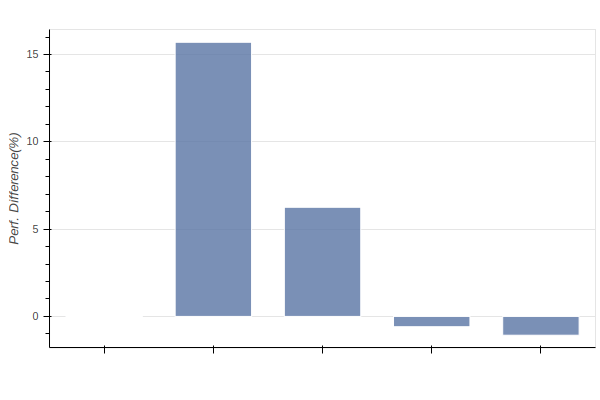

In [23]:
bar.output_backend = "svg"
export_svgs(bar, filename="xgb_vs_lgbm_performance.svg")
display(SVG('xgb_vs_lgbm_performance.svg'))

From the table as well as the plots below we can see that overall the difference in performance is quite small. LightGBM though is 2 to over 10 times quicker than XGBoost.